<a href="https://colab.research.google.com/github/galrat/license_UM/blob/main/UM2018_2022_analysis_of_lisense_data_for_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

План анализа
1.	Количество заявок по годам (ИЗ)
2.	Количество RU заявителей в общем числе
3.	Количество выданных патентов
4.	Влияние беспошлинного патентования.
5.	Скорость принятия решения по заявкам
6.	Количество экспертиз по существу на 10 тысяч заявок
7.	МПК, по которым подают заявки и выдают патенты
8.	Распределение заявок и патентов по 4 категориям
9.	Поддержание патентов в силе, кто поддерживает по категориям


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

from datetime import datetime
from matplotlib.pyplot import figure

In [ ]:
heads = ['application number', 'application url', 'INV/UM', 'filing date', 'patent number', 'patent url', 'PCT app', 'PCT publication', 'applicant', 'authors',
            'formal exam', 'substantive exam dates', 'substantive exam amount', 'refuse date', 'withdrawal date', 'grant date', 'ipc', 'claims', 'status', 'title',
           'address', 'alienation', 'license', 'pledge', 'abstract']

In [ ]:
# задаю цвета для всех графиков
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# функции

In [ ]:
def app_categories(applicants, authors):
  '''
  get applicants names, authors names
  return
  - values - number of applicants in 5 types = ['no_data', 'education', 'government', 'legal', 'individual']
  - app_type_col - column with 0, 1, 2, 3, 4 which correspond to types
  - phy_app - number of autors which are applicants

  '''
  print('total documents', len(applicants))

  edu = 0 # 1
  gov = 0 # 2
  leg = 0 # 3
  phy = 0 # 4
  no_data = 0
  phy_app = 0
  app_type_col = []

  education = ['бразован', 'нститут', 'ниверс', 'ЮНИВЕРСИТИ', 'юниверсити', 'УНИВЕР', 'ИНСТИТЬЮТ', 'ИНСТИТУТ', 'ЮНИВЕРСИТЕ', 'ФГБОУ', 'ИМАШ РАН', 'ИВС РАН',
               'ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ', 'НАУЧНЫЙ ЦЕНТР', 'ГосНИИ', 'ИССЛЕДОВАТЕЛЬСКИЙ ЦЕНТР',
               'БЮДЖЕТНОЕ НАУЧНОЕ УЧРЕЖДЕНИЕ', 'научно-исследовательское учреждение', 'академия', 'образовательная организация',
               'Сколково', 'Научный центр', 'научно-практический центр', 'аучный центр', 'Фонд', 'ФНЦ',
               'аучно-технический центр', 'НАУЧНО-ПРОИЗВОДСТВЕННОЕ ОБЪЕДИНЕНИЕ', 'образовательное учреждение',
               'бразован', 'нститут', 'ниверс', 'ЮНИВЕРСИТИ', 'юниверсити', 'УНИВЕР', 'ИНСТИТЬЮТ', 'ИНСТИТУТ', 'ЮНИВЕРСИТЕ', 'ФГБОУ', 'ИМАШ РАН', 'ИВС РАН', 'учреждение науки', 'аучный центр', 'научно-производственный центр',
               'исследовательский центр', 'Научно-учебный центр', 'НАУЧНО-ОБРАЗОВАТЕЛЬНЫЙ ЦЕНТР',
               'ТЕХНИКУМ', 'НАУЧНО-ИССЛЕДОВАТЕЛЬСКИЙ ИСПЫТАТЕЛЬНЫЙ ЦЕНТР'
               ]
  government = ['осударственн', 'министерство', 'Российская Федерация', 'государственное бюджетное учреждение', 'ФГБНУ', 'ойсковая часть', 'азенное учреждение',
                'ФБУ', 'ФГУП', 'больница', 'ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ',
                'Министерство', 'Росконгресс', 'Федеральное агентство', 'ФГБУ', 'Фонд поддержки', 'МИНИСТЕРСТВО',
                'БОЛЬНИЦА', 'ФЕДЕРАЛЬНОЕ КАЗЕННОЕ ПРЕДПРИЯТИЕ', 'Федеральное казенное предприятие',
                'Автономное учреждение "Технопарк - Мордовия" (RU)', 'ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ',
                'Федеральное казенное предприятие', 'ФГАУ', 'Федеральный центр', "ФКУ", 'Центральный банк Российской Федерации',
                'ФКП ']
  legal = ['ООО', 'бщество', 'ЛТД.', 'ЛИМИТЕД', 'КОРПОРЕЙШН', 'ИНК.', 'Лимитед', 'ИНКОРПОРЕЙТЕД', 'ГМБХ', 'КОНИНКЛЕЙКЕ', 'ИНТЕРНЭШНЛ', 'ФРАНС', 'ЛЛС',
           'КАЙСЯ', 'С.П.А', 'С.А.', 'ЛТД', 'РусКомПолимер',
          ' АГ', 'СИМЕНС', 'КОМПАНИ', 'Лтд', 'КОРПОРЭЙШН', 'ЭЛЕКТРОНИКС', 'Компани', 'ОБЩЕСТВО', 'ЭлЭлСи', 'ХОЛДИНГ', 'БАСФ', 'ООО', 'ГмбХ', 'Инк.',
           'А/С', 'АКЦИЕНГЕЗЕЛЛЬШАФТ', 'с ограниченной ответственностью',
          'АКЦИЕНГЕЗЕЛЬШАФТ', 'С.Р.Л.', ' АБ ', 'ЛЛК', 'Акциенгезельшафт', ' СПА ', 'СОЛЮШНС', 'ЗАО', 'ПАО', 'АКТИЕНГЕЗЕЛЛЬШАФТ', 'Текнолоджиз',
          'олюшн', 'ЭлЭЛСи', 'орпорейшн', 'ГРУП', 'ДиЭмСиСи', '(ПАБЛ)', 'ЭЛЕКТРИК', 'ТЕКНОЛО', 'АО ', 'БОЛАГЕТ', 'САФРАН', ' ОЙ ', 'ОЮЙ', 'ОЙЙ',
          ' САС ', ' СА ', ' АС ', 'СОЛЮШН', ' ИНК ', ' НВ ', 'АКТИЕБОЛАГ', 'ГОБЭН', 'ИНТЕРНЕЙШНЛ', 'ЛЛЦ', 'СЕРВИС', 'ФАРМА', 'ЭЛЭЛСИ',
           'АССОЦИАЦИЯ РАЗВИТИЯ ФИНАНСОВЫХ ТЕХНОЛОГИЙ',
          'убличное акционерное', 'OOO', 'акрытого акционерного общества', 'кооператив', 'КООПЕРАТИВ',
          'Частное учреждение здравоохранения', 'с ограниченной ответсвеностью',
           'Ленинградский областной центр авиационного технического творчества', 'Ассоциация', 'кционерная организация',
           'организация', 'АССОЦИАЦИЯ', 'ЧАСТНОЕ УЧРЕЖДЕНИЕ', 'астное учреждение', 'АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ',
           'Союз', 'БУРИНТЕХ', 'ЦРПИ', 'Сонневиль']
  physic = [' оглы', 'анович ', 'СЕРГЕ', 'ВЛАДИМИР', 'ЕВИЧ ', 'ОВИЧ ', 'Чон-Ын', 'ЦЗИНЬ, ГЭ', 'Цой Валентин',
            'Хамама Зина (RU)', 'Федан Дмитрий (RU)', 'Мд. Анварул Азим (RU)', 'Перцовский Давид (RU)', 'Цой ',
            'Дорошенко Джассер', 'Шахин Махмуд', 'Хаят Шаукат']
            #'Оденцов В.А.','Абрамов Б.Н.',]


  others = []
  counter = 0
  for ap, au in zip(applicants, authors):
    counter += 1
    #print(counter, 'applicants, authors', ap, au)
    if ap == 'no_data':
      no_data += 1
      app_type_col.append(0)
      continue

    if ap == au:
      #print('ap == au')
      phy += 1
      phy_app += 1
      app_type_col.append(4)
      continue

    if sum([x in ap for x in legal]):
      #print('leg')
      leg += 1
      app_type_col.append(3)
      continue

    if sum([x in ap for x in education]):
      #print('educ')
      edu += 1
      app_type_col.append(1)
      continue

    if sum([x in ap for x in government]):
      #print('gov')
      gov += 1
      app_type_col.append(2)
      continue

    if sum([x in ap for x in physic]):
      #print('physic')
      phy += 1
      app_type_col.append(4)
      continue

    # БОЛЬШАЯмаленькие пробел БОЛЬШАЯмаленькие пробел БОЛЬШАЯмаленькие
    name_pattern = r'[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+'
    if len(re.findall(name_pattern, ap)) != 0:
      phy += 1
      app_type_col.append(4)
      continue

    # БОЛЬШАЯ ФАМИЛИЯ маленькое имя
    name_pattern = r'[А-ЯЁ]+ [А-ЯЁ][а-яё]+'
    if len(re.findall(name_pattern, ap)) != 0:
      phy += 1
      app_type_col.append(4)
      continue

    # Фамилия И.О.
    ap = ap.replace(' .', '').replace('.', '')
    name_pattern = r'[А-ЯЁ][а-яё]+\s[А-ЯЁ][А-ЯЁ]'
    if len(re.findall(name_pattern, ap)) != 0:
      phy += 1
      app_type_col.append(4)
      continue

        # всякие исключения
    if 'Мешенгиссер Юрий' in ap or 'Газимиев Магомед-Салах Алхазурович' in ap or 'НАСЫРОВА НАДЕЖДА ИГОРЕВНА' in ap or ap in 'Саламех Али':
      phy += 1
      app_type_col.append(4)
      continue
            # всякие исключения
    if 'Саламех Али' in ap or 'Ван Сяолун' in ap or 'Фаизова Алина' in ap or 'Халиков Хашимбек' in ap:
      phy += 1
      app_type_col.append(4)
      continue

    others.append(ap)
    app_type_col.append(0)


    #print()
    #break
  #print('app_type_col', app_type_col)
  if len(others):
    print('количество оставшихся', len(others)) # почти 100%, что все others - это коммерческ.ческ.
    print('оставшиеся', others)
    for other in others:
      print('others', other)
  if len(applicants) != no_data + edu + gov + leg + phy + len(others):
    print('sum check', no_data + edu + gov + leg + phy + len(others))
  #print('количество авторов одновременно и заявителей:', phy_app)


  data = {}
  values = [no_data, edu, gov, leg, phy]
  types = ['no_data', 'education', 'government', 'legal', 'individual']
  for value, key in zip(values, types):
    data[key] = value


  return values, app_type_col, phy_app

# Часть, связанная с лицензиями

## defs

In [ ]:
def owner_license_type(license_data_unique):
  owner_types = ['education', 'government', 'legal', 'physic']
  licens_types = license_data_unique['license type details'].value_counts().index.to_list()
  sub_data1 = pd.DataFrame()
  sub_data2 = pd.DataFrame()
  license_owner_types = {}

  for owner_type in owner_types:
    try:
      sub_data1 = license_data_unique[license_data_unique[owner_type]==1]
    except:
      sub_data1 = pd.DataFrame()
    license_data = []
    for licens_type in licens_types:
      try:
        sub_data2 = sub_data1[sub_data1['license type details']==licens_type]
      except:
        sub_data2 = pd.DataFrame()
      license_data.append(len(sub_data2))
    license_owner_types[owner_type] = license_data
  #print('распределение по типам заявителей и типам распоряжений', license_owner_types)
  return license_owner_types, licens_types

In [ ]:
def ru_not_ru(data):
  # количество RU-не RU распорядителей
  license_data_unique_ru = data[data['owner'].str.contains('RU')]
  ru_license = len(license_data_unique_ru)
  # количество заруб распорядителей
  not_ru_license = len(data) - len(license_data_unique_ru)
  print('общее количество распоряжений', len(data),
        '\nколичество распоряжений у Заруб распорядителей', len(data) - len(license_data_unique_ru))
  print('количество распоряжений у RU распорядителей', len(license_data_unique_ru))

  ru_patents = len(set(license_data_unique_ru['patent number']))
  not_ru_patents = len(set(data['patent number'])) - len(set(license_data_unique_ru['patent number']))
  print('общее количество патентов', len(set(data['patent number'])),
  '\nколичество патентов у Заруб распорядителей',
        len(set(data['patent number'])) - len(set(license_data_unique_ru['patent number'])))
  print('количество патентов у RU распорядителей', len(set(license_data_unique_ru['patent number'])))

  # зарубежные распорядители наименования
  foreign_owners = []
  for i in data['owner'].value_counts().index:
    if ('RU') not in i:
      foreign_owners.append(i)
  print('foreign_owners', foreign_owners)

  foreign_licenses_title = []
  foreign_licenses_patent_number = []
  not_ru_numbers = []
  for i in foreign_owners:
    not_ru_numbers.append(len(data[data['owner']==i]))
    #print('foreign_owners title', (data[data['owner']==i]['title'].values.tolist()))
    foreign_licenses_title += data[data['owner']==i]['title'].values.tolist()
    foreign_licenses_patent_number += data[data['owner']==i]['patent number'].values.tolist()
  print('количеста распоряжений по правообладателям', not_ru_numbers)
  #print('названия патентов заруб распорядителей', foreign_licenses_title)
  #print('номера патентов зарубежных распорядителей', foreign_licenses_patent_number)
  print('количество патентов зарубежных распорядителей', len(set(foreign_licenses_patent_number)))
  return ru_license, not_ru_license, ru_patents, not_ru_patents

In [ ]:
def app_categories_2(column):
  '''
  column - column from dataframe for dividing into categories
  return vocabulary which comprise 4 categories and number of applicants in the categories
  '''
  edu_group = []
  leg_group = []
  phy_group = []
  gov_group = []

  grouped_cat = []
  applicants = column # column
  print('total documents', len(applicants))
  edu = 0
  gov = 0
  leg = 0
  phy = 0
  no_data = 0
  appl = []
  app_edu = []
  app_gov = []
  app_leg = []
  app_phy = []


  education = ['бразован', 'нститут', 'ниверс', 'ЮНИВЕРСИТИ', 'юниверсити', 'УНИВЕР', 'ИНСТИТЬЮТ', 'ИНСТИТУТ', 'ЮНИВЕРСИТЕ', 'ФГБОУ', 'ИМАШ РАН', 'ИВС РАН', 'учреждение науки', 'аучный центр', 'научно-производственный центр',
               'исследовательский центр', 'Научно-учебный центр']
  government = ['осударственн', 'министерство', 'Российская Федерация', 'государственное бюджетное учреждение', 'ФГБНУ', 'ойсковая часть', 'азенное учреждение', 'ФБУ', 'ФГУП',
                'Министерство обороны', 'Росконгресс']
  legal = ['ООО', 'бщество', 'ЛТД.', 'ЛИМИТЕД', 'КОРПОРЕЙШН', 'ИНК.', 'Лимитед', 'ИНКОРПОРЕЙТЕД', 'ГМБХ', 'КОНИНКЛЕЙКЕ', 'ИНТЕРНЭШНЛ', 'ФРАНС', 'ЛЛС', 'КАЙСЯ', 'С.П.А', 'С.А.', 'ЛТД',
          ' АГ', 'СИМЕНС', 'КОМПАНИ', 'Лтд', 'КОРПОРЭЙШН', 'ЭЛЕКТРОНИКС', 'Компани', 'ОБЩЕСТВО', 'ЭлЭлСи', 'ХОЛДИНГ', 'БАСФ', 'ООО', 'ГмбХ', 'Инк.', 'А/С', 'АКЦИЕНГЕЗЕЛЛЬШАФТ',
          'АКЦИЕНГЕЗЕЛЬШАФТ', 'С.Р.Л.', ' АБ ', 'ЛЛК', 'Акциенгезельшафт', ' СПА ', 'СОЛЮШНС', 'ЗАО', 'ПАО', 'АКТИЕНГЕЗЕЛЛЬШАФТ', 'Текнолоджиз',
          'олюшн', 'ЭлЭЛСи', 'орпорейшн', 'ГРУП', 'ДиЭмСиСи', '(ПАБЛ)', 'ЭЛЕКТРИК', 'ТЕКНОЛО', 'АО ', 'БОЛАГЕТ', 'САФРАН', ' ОЙ ', 'ОЮЙ', 'ОЙЙ',
          ' САС ', ' СА ', ' АС ', 'СОЛЮШН', ' ИНК ', ' НВ ', 'АКТИЕБОЛАГ', 'ГОБЭН', 'ИНТЕРНЕЙШНЛ', 'ЛЛЦ', 'СЕРВИС', 'ФАРМА', 'ЭЛЭЛСИ', 'АССОЦИАЦИЯ РАЗВИТИЯ ФИНАНСОВЫХ ТЕХНОЛОГИЙ',
           'убличное акционерно', 'OOO', 'кционерн']
  physic = [' оглы', 'анович ', 'СЕРГЕ', 'ВЛАДИМИР', 'ЕВИЧ ', 'ОВИЧ ', 'Чон-Ын', 'ЦЗИНЬ, ГЭ', 'Цой Валентин']


  others = []
  for applicant in applicants[:]:
    phy_trigger = 0
    edu_trigger = 0
    gov_trigger = 0
    leg_trigger = 0
    #print('\n\n', applicant)
    trigger = 0

    for l in legal:
      if l in applicant:
        leg += 1
        leg_trigger = 1
        #print('education')
        trigger = 1
        app_leg.append(applicant)
        break

    if not trigger:
      for e in education:
        if e in applicant:
          edu += 1
          edu_trigger = 1
          #print('education')
          trigger = 1
          app_edu.append(applicant)
          break

    if not trigger:
      for g in government:
        if g in applicant:
          gov += 1
          gov_trigger = 1
          #print('government')
          trigger = 1
          app_gov.append(applicant)
          break

    if not trigger:
      for l in legal:
        if l in applicant:
          leg += 1
          leg_trigger = 1
          #print('legal')
          trigger = 1
          app_leg.append(applicant)
          break

    if not trigger:
      for p in physic:
        if p in applicant:
          phy += 1
          phy_trigger = 1
          #print('physic', applicant)
          trigger = 1
          app_phy.append(applicant)
          break

    if not trigger:
      if (len(re.findall(r'\s', applicant.split(' (')[0]))) == 0 or len(re.findall(r'\.', applicant.split('(')[0])) > 0 or len(re.findall(r'\s', applicant.split(' (')[0])) > 3:
        #print()
        leg += 1
        leg_trigger = 1
        app_leg.append(applicant)
        #print('legal')
        trigger = 1

      #print(applicant)
      if not trigger:
        # БОЛЬШАЯмаленькие пробел БОЛЬШАЯмаленькие пробел БОЛЬШАЯмаленькие
        name_pattern = r'[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+'
        if len(re.findall(name_pattern, applicant)) != 0:
          phy += 1
          phy_trigger = 1
          app_phy.append(applicant)
          #print('physic', applicant)
          trigger = 1

      if not trigger:
        # БОЛЬШАЯ ФАМИЛИЯ маленькое имя
        name_pattern = r'[А-ЯЁ]+ [А-ЯЁ][а-яё]+'
        if len(re.findall(name_pattern, applicant)) != 0:
          phy += 1
          phy_trig = 1
          #print('physic', applicant)
          app_phy.append(applicant)
          trigger = 1

        # всякие исключения
        if not trigger:
          if 'Мешенгиссер Юрий' in applicant or 'Газимиев Магомед-Салах Алхазурович' in applicant or 'НАСЫРОВА НАДЕЖДА ИГОРЕВНА' in applicant:
            phy += 1
            phy_trig = 1
            #print('physic', applicant)
            app_phy.append(applicant)
            trigger = 1


    if trigger == 0:
      others.append(applicant)

    if edu_trigger:
      edu_group.append(1)
    else:
      edu_group.append(0)
    if gov_trigger:
      gov_group.append(1)
    else:
      gov_group.append(0)
    if phy_trigger:
      phy_group.append(1)
    else:
      phy_group.append(0)
    if leg_trigger:
      leg_group.append(1)
    else:
      leg_group.append(0)



  #print(edu_group)
  #print(gov_group)
  #print(phy_group)
  #print(leg_group)
  #print('total', edu + gov + leg + phy)
  data = {}
  values = [edu, gov, leg, phy]
  types = ['education', 'government', 'legal', 'physic']
  for value, key in zip(values, types):
    data[key] = value
  print('not grouped - shall be []', others)

  return values, edu_group, gov_group, leg_group, phy_group

## code

In [ ]:
years = ['2018', '2019', '2020', '2021', '2022']

In [ ]:
# проверка, все ли распоряжения попали в данные для обработки
patent_type = 'UM' # INV or UM
license_data_df = pd.DataFrame()
license_data_voc = {}

header = ['patent number', 'title', 'patent url', 'owner', 'ipc', 'license type', 'license number date', 'licensor', 'licensee', 'license type details', 'license conditions', 'address']
for year in years[:]:
  print('год', year)
  license_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Патентование/парсинг и анализ заявок на ИЗ и ПМ/data/license/' + str(year) + patent_type + '_licenses_info.csv', sep='\t', encoding='utf8', header=None)
  license_data_df = license_data_df[[columns for columns in range(1, 13)]]
  license_data_df.columns = header
  license_data_df = license_data_df.drop(index= 0)
  license_data_df = license_data_df[license_data_df['patent number'] != 'h']
  license_data_voc[year] = license_data_df
print('downloaded')


год 2018
год 2019
год 2020
год 2021
год 2022
downloaded


In [ ]:
# убираю лишнюю информацию, привожу к более удобному виду
total = np.array([])
unique = np.array([])
open_lic = np.array([])
license_data_final_voc = {}

for year in years[:]:
  print('year', year)
  license_data = license_data_voc[year]
  total = np.append(total, len(license_data['patent number']))
  unique = np.append(unique, len(set(license_data['patent number'])))
  print('total', total, 'unique', unique)

  # licensee correction
  new_licensee = []
  for i in license_data.licensee:
    #print(i.split('\n')[0])
    new_licensee.append(i.split('\n')[0])
  license_data.licensee = new_licensee

  # license_type_details correction
  new_license_type_details = []
  for i in license_data['license type details']:
    #print(i.split('\n')[0])
    new_license_type_details.append(i.split('\n')[0])
  license_data.license_type_details = new_license_type_details

  # open license removing
  #print(license_data[license_data['license type'] == 'Открытая лицензия']['patent number'])
  previous = set(license_data[license_data['license type'] == 'Открытая лицензия']['patent number'])
  open_lic = np.append(open_lic, len(license_data[license_data['license type'] == 'Открытая лицензия']))
  print('количество открытых лицензий', open_lic)
  license_data = license_data[license_data['license type'] != 'Открытая лицензия']
  print('total', len(license_data['patent number']), 'unique', len(set(license_data['patent number'])))
  print('intersection - открытые лицензии, по которым есть лицензия', set.intersection(previous, set(license_data['patent number'])))

  ## save unique only
  # part 1 removing copies with the same contract number
  license_data_dupl = license_data[license_data.duplicated(subset=['patent number', 'license number date'])]
  print('number of duplicates, где повторяются распоряжения и изменения', len(license_data_dupl))
  license_data_unique = license_data.drop_duplicates(subset=['patent number', 'license number date'], keep='first', inplace=False, ignore_index=False)

  # part 2 removing alienations between the same participants
  license_data_dupl2 = license_data_unique[(license_data_unique.duplicated(subset=['patent number', 'owner', 'license type', 'licensor', 'licensee'])&(license_data_unique['license type details']=='Договор отчуждения'))]
  print('number of duplicates2, где несколько раз фиксируется идентичное отчуждение', len(license_data_dupl2))
  license_data_unique = license_data_unique.drop_duplicates(subset=['patent number', 'owner', 'license type', 'licensor', 'licensee'], keep='first', inplace=False, ignore_index=False)

  # change in registration details removing
  #print('changes\n', license_data_unique[license_data_unique['license type'] == 'QZ9K Государственная регистрация изменений, касающихся предоставления права использования по договору'])
  print('количество зарегистрированных изменений, попавших в данные', len(license_data_unique[license_data_unique['license type'] == 'QZ9K Государственная регистрация изменений, касающихся предоставления права использования по договору']))
  license_data_unique = license_data_unique[license_data_unique['license type'] != 'QZ9K Государственная регистрация изменений, касающихся предоставления права использования по договору']

  # замена сходных терминов одним
  license_data_unique.loc[license_data_unique['license type details']=='о последующем залоге исключительного права', ['license type details']] = 'о залоге исключительного права'
  license_data_unique.loc[license_data_unique['license type details']=='об отчуждении исключительного права', ['license type details']] = 'Договор отчуждения'

  print('number of unique', len(license_data_unique), ', number of RU unique', len(license_data_unique[license_data_unique['owner'].str.contains('RU')]))
  license_data_final_voc[year] = license_data_unique

  print('общее количество уникальных распоряжений', len(license_data_unique['patent number']),
        ', количество патентов с раcпоряжениями', len(set(license_data_unique['patent number'])),
        ', количество RU патентов с раcпоряжениями', len(set(license_data_unique[license_data_unique['owner'].str.contains('RU')]['patent number'])),
        ', difference', len(license_data_unique['patent number']) - len(set(license_data_unique['patent number'])))

  print('==============================\n\n')

year 2018
total [1564.] unique [809.]
количество открытых лицензий [16.]
total 1548 unique 795
intersection - открытые лицензии, по которым есть лицензия {182520, 190111}
number of duplicates, где повторяются распоряжения и изменения 141
number of duplicates2, где несколько раз фиксируется идентичное отчуждение 267
количество зарегистрированных изменений, попавших в данные 25
number of unique 1092 , number of RU unique 887
общее количество уникальных распоряжений 1092 , количество патентов с раcпоряжениями 783 , количество RU патентов с раcпоряжениями 675 , difference 309


year 2019
total [1564. 1337.] unique [809. 751.]
количество открытых лицензий [16.  5.]
total 1332 unique 746
intersection - открытые лицензии, по которым есть лицензия set()
number of duplicates, где повторяются распоряжения и изменения 109
number of duplicates2, где несколько раз фиксируется идентичное отчуждение 210
количество зарегистрированных изменений, попавших в данные 32
number of unique 973 , number of RU 

<ipython-input-10-4cd39c90ec08>:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  license_data.license_type_details = new_license_type_details
<ipython-input-10-4cd39c90ec08>:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  license_data.license_type_details = new_license_type_details
<ipython-input-10-4cd39c90ec08>:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  license_data.license_type_details = new_license_type_details
<ipython-input-10-4cd39c90ec08>:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  license_data.

In [ ]:
license_data_final_voc['2018'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 1 to 1564
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   patent number         1092 non-null   int64 
 1   title                 1092 non-null   object
 2   patent url            1092 non-null   object
 3   owner                 1092 non-null   object
 4   ipc                   1092 non-null   object
 5   license type          1092 non-null   object
 6   license number date   1092 non-null   object
 7   licensor              1092 non-null   object
 8   licensee              1092 non-null   object
 9   license type details  1092 non-null   object
 10  license conditions    995 non-null    object
 11  address               1092 non-null   object
dtypes: int64(1), object(11)
memory usage: 110.9+ KB


In [ ]:
# add column  RU-not RU
for year in license_data_final_voc.keys():
  license_data_final_voc[year]['RU'] = license_data_final_voc[year]['owner'].apply ( lambda x: 1 if 'RU' in x else 0)


In [ ]:
# add license date
license_date_df = pd.DataFrame()
for year in years:
  license_data_final_voc[year]['license date'] = license_data_final_voc[year]['license number date'].apply(lambda x: x.split(' ')[0].split('.')[-1].strip())


In [ ]:
# add column of owner type (education, government, commersial, individual)
for year in years:
  groups_data = app_categories(license_data_final_voc[year]['owner'], license_data_final_voc[year]['title'])
  license_data_final_voc[year].insert(len(license_data_final_voc[year].columns), 'owner type', groups_data[1])


total documents 1092
total documents 973
total documents 541
total documents 586
total documents 252


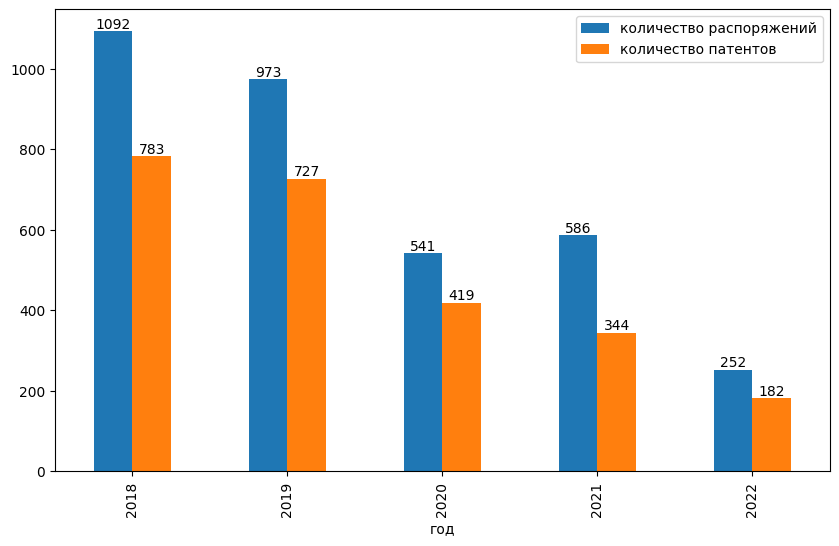

In [ ]:
figsize = (10, 6)
licenses_number = []
patents_number = []
for year in years:
  licenses_number.append(len(license_data_final_voc[year]))
  patents_number.append(len(set(license_data_final_voc[year]['patent number'])))
general_dynamics_df = pd.DataFrame([licenses_number, patents_number]) #,
general_dynamics_df = general_dynamics_df.transpose()
columns=['количество распоряжений', 'количество патентов']
general_dynamics_df.columns = columns
general_dynamics_df.index = years

ax = general_dynamics_df.plot(kind='bar', figsize=figsize, xlabel='год')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
#ax.set_ylabel('Количество распоряжений/патентов')
plt.show()

<Axes: >

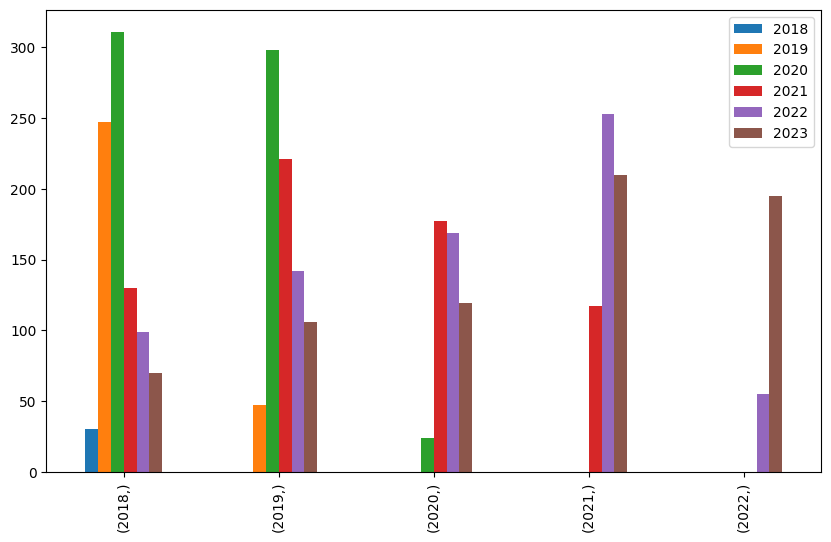

In [ ]:
# год заключения договора только RU
license_date_df = pd.DataFrame()
for year in years:
  license_date_df = pd.concat([license_date_df, license_data_final_voc[year][license_data_final_voc[year]['RU']==1]['license date'].value_counts()], axis=1)
license_date_df.columns=[years]
try:
  license_date_df = license_date_df.drop(index=['2011'])
except:
  print('all ok')
license_date_df.sort_index(inplace=True)
license_date_df.transpose().plot(kind='bar', color=colors, figsize=(10, 6))

In [ ]:
# убираю дату осуществления распоряжения

for year in license_data_final_voc.keys():
  #print(license_data_voc[year]['license type details'])
  license_data_final_voc[year]['license type details'] = license_data_final_voc[year]['license type details'].apply(lambda x: x.split('Дата')[0].strip())
  print(license_data_final_voc[year]['license type details'].value_counts())
  print(license_data_final_voc[year]['license date'].value_counts())
  break

лицензионный                      543
Договор отчуждения                429
о залоге исключительного права     99
сублицензионный                    21
Name: license type details, dtype: int64
2020    315
2019    259
2023    253
2021    132
2022    102
2018     31
Name: license date, dtype: int64


In [ ]:
# создаю словарь, в котором сохраняю только уникальные патенты, по которым было распоряжение
unique_license_data_final_voc = {}
for year in years:
  unique_license_data_final_voc[year] = license_data_final_voc[year].drop_duplicates(subset=['patent number'], keep='first', inplace=False, ignore_index=False)


[[675, 887, 108, 205], [642, 815, 85, 158], [390, 489, 29, 52], [338, 580, 6, 6], [181, 250, 1, 2]]


<ipython-input-19-313efde29b93>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_line.append([len(unique_license_data_final_voc[year][license_data_final_voc[year]['RU']==1]), # RU patents
<ipython-input-19-313efde29b93>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(unique_license_data_final_voc[year][license_data_final_voc[year]['RU']==0]), # not RU patents


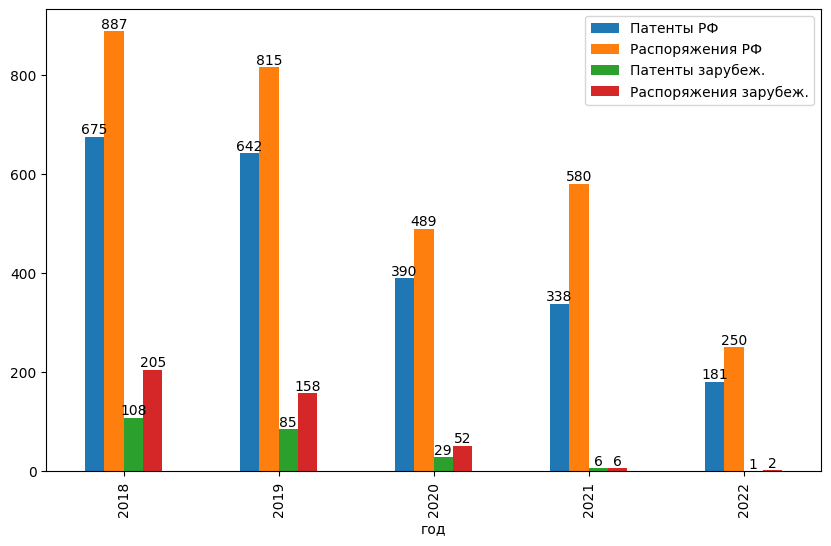

In [ ]:
# разделяю владельцев на RU - не RU
data_line = []

for year in years:
  data_line.append([len(unique_license_data_final_voc[year][license_data_final_voc[year]['RU']==1]), # RU patents
                   len(license_data_final_voc[year][license_data_final_voc[year]['RU']==1]), # RU license
                   len(unique_license_data_final_voc[year][license_data_final_voc[year]['RU']==0]), # not RU patents
                   len(license_data_final_voc[year][license_data_final_voc[year]['RU']==0])] # not RU license
                   )
print(data_line)

df_ru_not_ru = pd.DataFrame(data_line, index=years, columns=['Патенты РФ', 'Распоряжения РФ', 'Патенты зарубеж.','Распоряжения зарубеж.'])
ax = df_ru_not_ru.plot(kind='bar', color=colors, figsize=figsize, xlabel='год')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])
plt.show()

In [ ]:
# создаю словарь с только RU правообладателями
license_data_voc_ru = {}
unique_license_data_voc_ru = {}
for year in years:
  license_data_voc_ru[year] = license_data_final_voc[year][license_data_final_voc[year]['RU']==1]
  unique_license_data_voc_ru[year] = unique_license_data_final_voc[year][unique_license_data_final_voc[year]['RU']==1]


2018
total documents 675
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 162, 8, 260, 245] сумма 675
already inserted
2019
total documents 642
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 151, 6, 220, 265] сумма 642
already inserted
2020
total documents 390
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 42, 11, 152, 185] сумма 390
already inserted
2021
total documents 338
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 33, 3, 146, 156] сумма 338
already inserted
2022
total documents 181
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 11, 5, 61, 104] сумма 181
already inserted


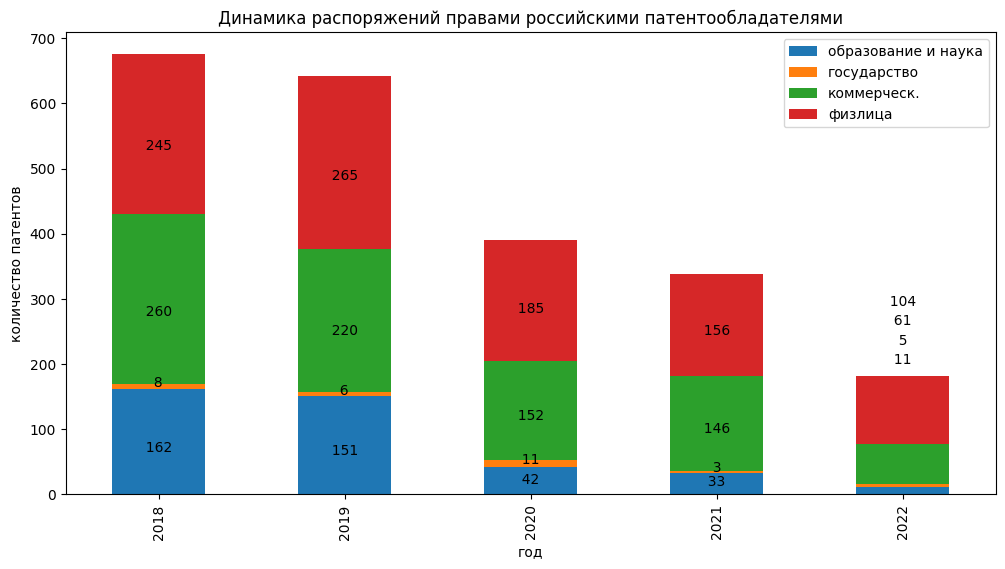

In [ ]:
# считаю именно !!!!!!!!patents!!!!!!!!!!!!!!
data_line = []
types_visualisation = ['образование и наука', 'государство', 'коммерческ.', 'физлица']
types = ['education', 'government', 'legal', 'physic']
for year in years:
  print(year)
  # смотрю распределение распорядителей по 4 категориям
  groups_data = app_categories(unique_license_data_voc_ru[year]['owner'], unique_license_data_voc_ru[year]['title'])
  #print(groups_data)
  print(types_visualisation, groups_data[0], 'сумма', sum(groups_data[0]))
  data_line.append(groups_data[0][1:])
  try:
    unique_license_data_voc_ru[year].insert(len(unique_license_data_voc_ru[year].columns), types[0], groups_data[1])
    unique_license_data_voc_ru[year].insert(len(unique_license_data_voc_ru[year].columns), types[1], groups_data[2])
    unique_license_data_voc_ru[year].insert(len(unique_license_data_voc_ru[year].columns), types[2], groups_data[3])
    unique_license_data_voc_ru[year].insert(len(unique_license_data_voc_ru[year].columns), types[3], groups_data[4])
  except:
    print('already inserted')
df_app_types = (pd.DataFrame(data_line, columns=types_visualisation, index=years))
df_app_types['years'] = years
license = df_app_types
ax = df_app_types.plot(x='years', y=types_visualisation, kind='bar', stacked=True, title='Динамика распоряжений правами российскими патентообладателями', color=colors, figsize=(12, 6), xlabel='год', ylabel='количество патентов', table=False)

for i in range(len(years)-1):
  total = 0
  for value in types_visualisation:
    plt.text(i, df_app_types[value].iloc[i]*0.4 + total, '  '+str(df_app_types[value].iloc[i]) + '  ', ha = 'center')
    total += df_app_types[value].iloc[i]

for i in range(len(years))[-1:]:
  total = 0
  for value in types_visualisation:
    plt.text(i, df_app_types[value].iloc[i]*0 +200 + total, '  '+str(df_app_types[value].iloc[i])+'  ', ha = 'center')
    total += 30
plt.show()

2018
total documents 887
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 172, 8, 369, 338] сумма 887
already inserted
2019
total documents 815
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 155, 7, 317, 336] сумма 815
already inserted
2020
total documents 489
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 45, 12, 191, 241] сумма 489
already inserted
2021
total documents 580
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 38, 5, 338, 199] сумма 580
already inserted
2022
total documents 250
['образование и наука', 'государство', 'коммерческ.', 'физлица'] [0, 15, 10, 111, 114] сумма 250
already inserted


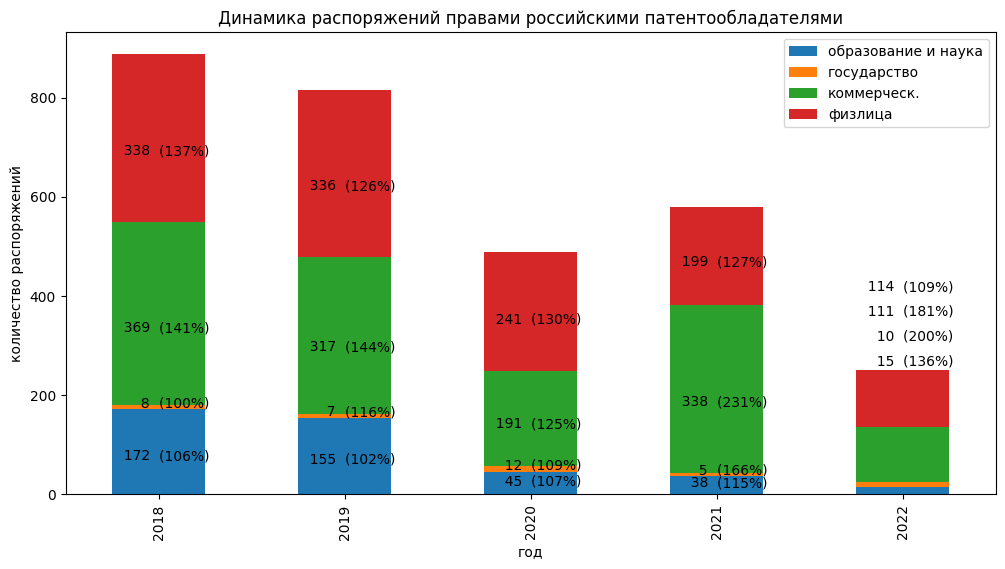

In [ ]:
# считаю только !!!!!!!!!распоряжения!!!!!!!!!
data_line = []
types_visualisation = ['образование и наука', 'государство', 'коммерческ.', 'физлица']
types = ['education', 'government', 'legal', 'physic']
for year in years:
  print(year)
  # смотрю распределение распорядителей по 4 категориям
  groups_data = app_categories(license_data_voc_ru[year]['owner'], license_data_voc_ru[year]['title'])
  #print(groups_data)
  print(types_visualisation, groups_data[0], 'сумма', sum(groups_data[0]))
  data_line.append(groups_data[0][1:])
  try:
    license_data_voc_ru[year].insert(len(license_data_voc_ru[year].columns), types[0], groups_data[1])
    license_data_voc_ru[year].insert(len(license_data_voc_ru[year].columns), types[1], groups_data[2])
    license_data_voc_ru[year].insert(len(license_data_voc_ru[year].columns), types[2], groups_data[3])
    license_data_voc_ru[year].insert(len(license_data_voc_ru[year].columns), types[3], groups_data[4])
  except:
    print('already inserted')
df_app_types = (pd.DataFrame(data_line, columns=types_visualisation, index=years))
df_app_types['years'] = years

persent_licenses_to_total_app = df_app_types[['образование и наука',	'государство',	'коммерческ.',	'физлица'	]].to_numpy()/license[['образование и наука',	'государство',	'коммерческ.',	'физлица'	]].to_numpy()*100
persent_licenses_to_total_app_df = pd.DataFrame(persent_licenses_to_total_app, columns=['образование и наука',	'государство',	'коммерческ.',	'физлица'	])

ax = df_app_types.plot(x='years', y=types_visualisation, kind='bar', stacked=True, title='Динамика распоряжений правами российскими патентообладателями', color=colors, figsize=(12, 6), xlabel='год', ylabel='количество распоряжений', table=False)

for i in range(len(years)-1):
  total = 0
  for value in types_visualisation:
    plt.text(i, df_app_types[value].iloc[i]*0.4 + total, '  '+str(df_app_types[value].iloc[i]) + '  ', ha = 'right')
    plt.text(i, df_app_types[value].iloc[i]*0.4 + total, '(' + str((int(persent_licenses_to_total_app_df[value].iloc[i])))+"%)   ", ha = 'left')
    total += df_app_types[value].iloc[i]

for i in range(len(years))[-1:]:
  total = 0
  for value in types_visualisation:
    plt.text(i, df_app_types[value].iloc[i]*0 +260 + total, '  '+str(df_app_types[value].iloc[i])+'  ', ha = 'right')
    plt.text(i, df_app_types[value].iloc[i]*0 +260 + total, '(' + str((int(persent_licenses_to_total_app_df[value].iloc[i])))+"%)   ", ha = 'left')
    total += 50
plt.show()

<Axes: >

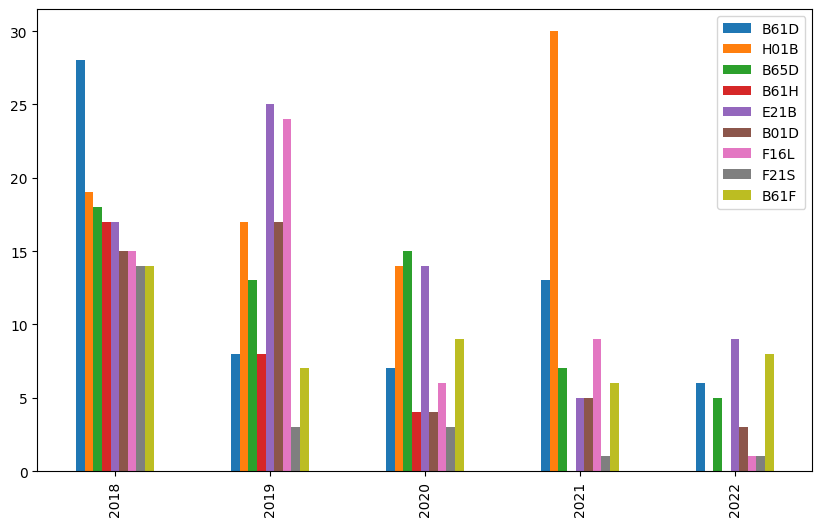

In [ ]:
# Посмотрим на динамику по МПК
ipcs = pd.DataFrame()
for year in years:
  ipcs = pd.concat([ipcs, unique_license_data_voc_ru[year]['ipc'].str[:4].value_counts()], axis=1)
ipcs.columns = years
ipcs = ipcs.iloc[:9].transpose()
ipcs.plot(kind='bar', figsize=figsize)



In [ ]:
ipcs

,B61D,H01B,B65D,B61H,E21B,B01D,F16L,F21S,B61F
2018,28.0,19.0,18.0,17.0,17.0,15.0,15.0,14.0,14.0
2019,8.0,17.0,13.0,8.0,25.0,17.0,24.0,3.0,7.0
2020,7.0,14.0,15.0,4.0,14.0,4.0,6.0,3.0,9.0
2021,13.0,30.0,7.0,NaN,5.0,5.0,9.0,1.0,6.0
2022,6.0,NaN,5.0,NaN,9.0,3.0,1.0,1.0,8.0


In [ ]:
for ipc in ipcs.columns:
  print(ipc)
  print(sum(ipcs[ipc].fillna(0).astype(int).values))
  print()

B61D
62

H01B
80

B65D
58

B61H
29

E21B
70

B01D
44

F16L
55

F21S
22

B61F
44



1. 183769, РЕЗЬБОВОЕ СОЕДИНЕНИЕ ОБСАДНЫХ ТРУБ
2. 181441, УСОВЕРШЕНСТВОВАННЫЙ ВЕРХНИЙ РОЛИК ДЛЯ РАЗДВИЖНЫХ СИСТЕМ
3. 184891, УСТРОЙСТВО ДЛЯ ВРЕМЕННОГО ХРАНЕНИЯ ОТХОДОВ
4. 188035, КАНИСТРА
5. 185559, МНОГОФУНКЦИОНАЛЬНЫЙ ТРЕХОСНЫЙ ВЕЗДЕХОД
6. 182077, КАБЕЛЬ КОНТРОЛЬНЫЙ
7. 187782, Канистра
8. 188036, Канистра
9. 184845, Предохранитель резьбы ниппельного элемента резьбовых соединений нефтегазопромысловых труб
10. 188030, Канистра



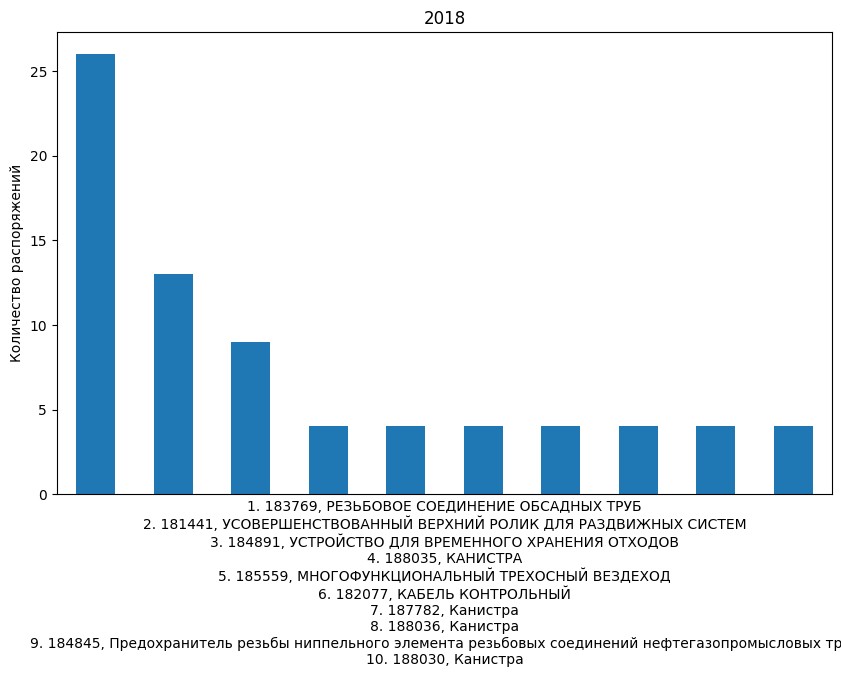

183769    26
181441    13
184891     9
188035     4
185559     4
Name: patent number, dtype: int64



++++++++++++++++++++++++ 2018 ++++++++++++++++++++++++++++
Первое место у патента 183769 , 
РЕЗЬБОВОЕ СОЕДИНЕНИЕ ОБСАДНЫХ ТРУБ
, патентообладатель -  Общество с ограниченной ответственностью "ТМК-Премиум Сервис" (RU)
. По этому патенту заключено  26  договоров распоряжений со следующими организациями: Акционерное общество "ТМК НГС-Нижневартовск" (RU),
Общество с ограниченной ответственностью "ПКНМ-Урал" (RU),
Акционерное общество "Орский машиностроительный завод" (RU),
Общество с ограниченной ответственностью "ТМК Нефтегазсервис-Бузулук" (RU),
Общество с ограниченной ответственностью "ВНИИБТ-Буровой инструмент" (RU),
Акционерное общество "АРТ-Оснастка" (RU),
Общество с ограниченной ответственностью "ЮниТек" (RU),
Акционерное общество "Волжский трубный завод" (RU),
Публичное акционерное общество "Таганрогский металлургический завод" (RU),
Публичное акционерное общество "Трубная Металлур

<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to

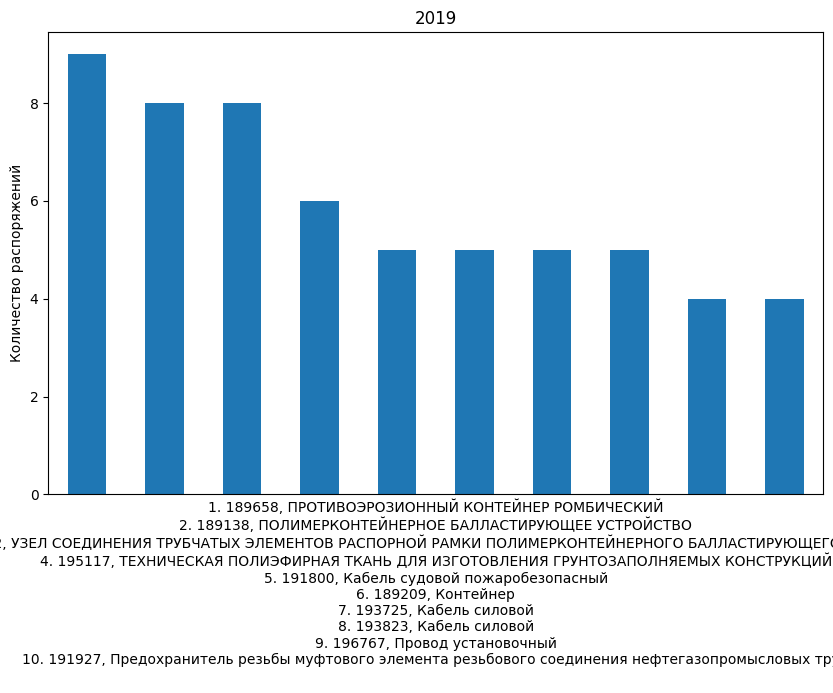

189658    9
189138    8
187432    8
195117    6
191800    5
Name: patent number, dtype: int64



++++++++++++++++++++++++ 2019 ++++++++++++++++++++++++++++
Первое место у патента 189658 , 
ПРОТИВОЭРОЗИОННЫЙ КОНТЕЙНЕР РОМБИЧЕСКИЙ
, патентообладатель -  Общество с ограниченной ответственностью "ПетроЗемПроект" (ООО "ПетроЗемПроект") (RU),Карташян Вадим Эдуардович (RU)
. По этому патенту заключено  9  договоров распоряжений со следующими организациями: Акционерное общество "Газпром СтройТЭК Салават" (RU),
Карташян Вадим Эдуардович (RU),
Карташян Владимир Эдуардович (RU),
Общество с ограниченной ответственностью "Производственное объединение КОЛЬЧУГИНОПРОМСНАБ" (RU),
Общество с ограниченной ответственностью "Управляющая компания "Меркури Кэпитал Траст" Доверительный управляющий Закрытым паевым инвестиционным фондом комбинированным "Проектные инвестиции - I" (RU),
Общество с ограниченной ответственностью "Управляющая компания "Меркури Кэпитал Траст" Доверительный управляющий Закрытым паевым

<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to

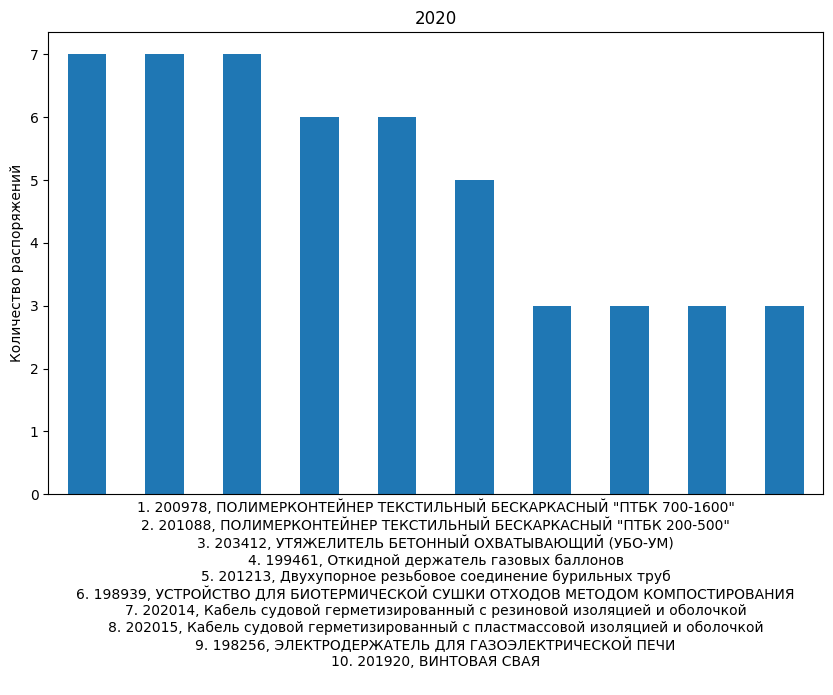

200978    7
201088    7
203412    7
199461    6
201213    6
Name: patent number, dtype: int64



++++++++++++++++++++++++ 2020 ++++++++++++++++++++++++++++
Первое место у патента 200978 , 
ПОЛИМЕРКОНТЕЙНЕР ТЕКСТИЛЬНЫЙ БЕСКАРКАСНЫЙ "ПТБК 700-1600"
, патентообладатель -  Карташян Владимир Эдуардович (RU)
. По этому патенту заключено  7  договоров распоряжений со следующими организациями: Акционерное общество "Газпром СтройТЭК Салават" (RU),
Общество с ограниченной ответственностью "Производственное объединение КОЛЬЧУГИНОПРОМСНАБ" (RU),
Общество с ограниченной ответственностью "Управляющая компания "Меркури Кэпитал Траст" Доверительный управляющий Закрытым паевым инвестиционным фондом комбинированным "Проектные инвестиции - I" (RU),
Общество с ограниченной ответственностью "Управляющая компания "Меркури Кэпитал Траст" Доверительный управляющий Закрытым паевым инвестиционным фондом комбинированным "ВерКон" (RU),
Общество с ограниченной ответственностью "Газпром стройТЭК" (RU),
Общество с о

<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to

1. 205188, Кабель силовой плоский
2. 205184, Кабель силовой плоский
3. 204458, Кабель силовой
4. 204739, Кабель контрольный
5. 204434, Кабель малогабаритный
6. 204424, Кабель управления
7. 207451, Кабель силовой, малоопасный по токсичности продуктов горения
8. 209007, Кабель силовой малоопасный по токсичности продуктов горения
9. 207449, Кабель силовой
10. 205297, Кабель контрольный малоопасный по токсичности продуктов горения



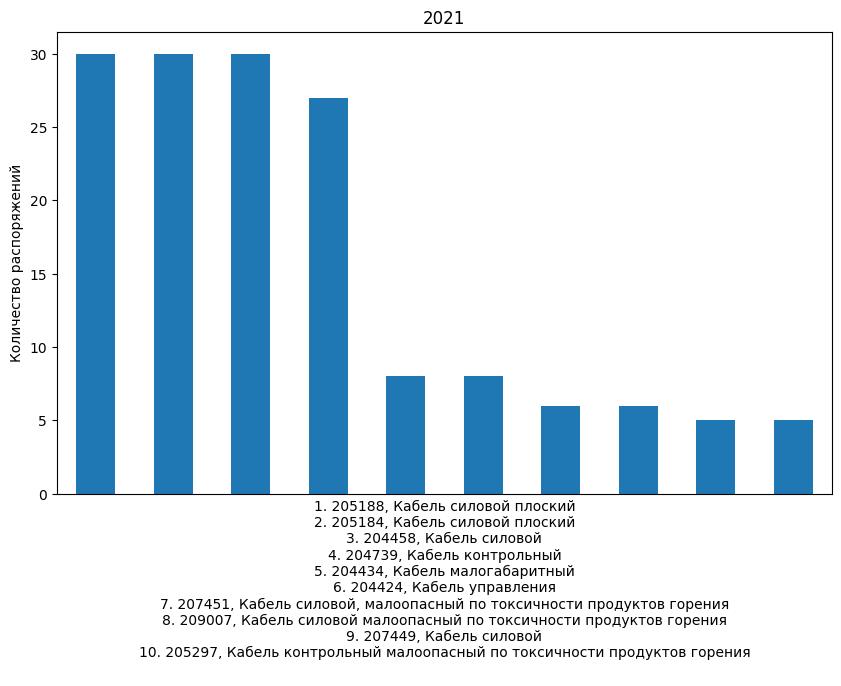

205188    30
205184    30
204458    30
204739    27
204434     8
Name: patent number, dtype: int64



++++++++++++++++++++++++ 2021 ++++++++++++++++++++++++++++
Первое место у патента 205188 , 
Кабель силовой плоский
, патентообладатель -  Открытое акционерное общество Всероссийский научно-исследовательский, проектно-конструкторский и технологический институт кабельной промышленности (RU)
. По этому патенту заключено  30  договоров распоряжений со следующими организациями: Общество с ограниченной ответственностью "Дмитров-Кабель" (RU),
Акционерное общество "Электрокабель» Кольчугинский завод" (RU),
Акционерное общество "Самарская кабельная компания" (RU),
Акционерное общество "Завод "Энергокабель" (RU),
Общество с ограниченной ответственностью "Ореол" (RU),
Общество с ограниченной ответственностью "Рыбинский кабельный завод" (RU),
Акционерное общество "Тверьэнергокабель" (RU),
Общество с ограниченной ответственностью "ЭМ-КАБЕЛЬ" (RU),
Общество с ограниченной ответственностью "Томский к

<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to

1. 214510, Блок питания на переключаемых дросселях
2. 215936, МОДУЛЬ ДЛЯ СБОРА ТВЕРДЫХ КОММУНАЛЬНЫХ ОТХОДОВ (URBAN 0.12)
3. 212105, МОДУЛЬ ДЛЯ СБОРА ТВЕРДЫХ КОММУНАЛЬНЫХ ОТХОДОВ
4. 215361, МОДУЛЬ ДЛЯ РАЗДЕЛЬНОГО СБОРА ТВЕРДЫХ КОММУНАЛЬНЫХ ОТХОДОВ
5. 217742, ОСТАНОВОЧНЫЙ ПАВИЛЬОН
6. 214262, Устройство автоматического гравитационного запирания дверей
7. 216565, МОДУЛЬ СВЕТОДИОДНЫЙ ДЛЯ СВЕТИЛЬНИКА
8. 211866, Транспортно-запускная система для мультикоптеров
9. 211187, ФИЛЬТРАЦИОННОЕ УСТРОЙСТВО ЛИВНЕВОГО СТОКА
10. 212587, КУЗОВ КРЫТОГО ГРУЗОВОГО ВАГОНА



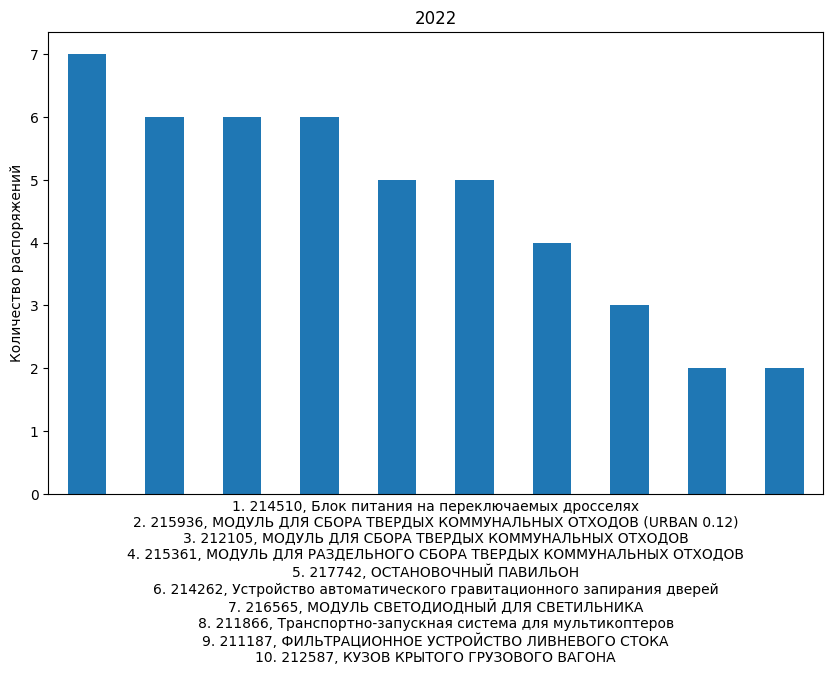

214510    7
215936    6
212105    6
215361    6
217742    5
Name: patent number, dtype: int64



++++++++++++++++++++++++ 2022 ++++++++++++++++++++++++++++
Первое место у патента 214510 , 
Блок питания на переключаемых дросселях
, патентообладатель -  Общество с ограниченной ответственностью "ФОРТИС" (RU)
. По этому патенту заключено  7  договоров распоряжений со следующими организациями: Общество с ограниченной ответственностью КОНСТРУКТОРСКОЕ БЮРО "НОРЛАБ" (RU),
Общество с ограниченной ответственностью "ФОРТИС" (RU),
Общество с ограниченной ответственностью "МЕТАЛЛВЕЛД" (RU),
Общество с ограниченной ответственностью "ЭНЕРГОСЕРВИС" (RU),
Общество с ограниченной ответственностью "ЭНЭФ ГРУПП" (RU),
Общество с ограниченной ответственностью "НОРГРАД" (RU),
Общество с ограниченной ответственностью ТОРГОВЫЙ ДОМ "НОРГРУПП" (RU)
Второе место у патента 215936 , 
МОДУЛЬ ДЛЯ СБОРА ТВЕРДЫХ КОММУНАЛЬНЫХ ОТХОДОВ (URBAN 0.12)
, патентообладатель -  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ КОНСТРУКТО

<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
<ipython-input-26-3760b61a6c70>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to

In [ ]:
# Самые успешные патенты
for year in years:
  top_patents = license_data_voc_ru[year]['patent number'].value_counts().iloc[:5]
  top_patents_visual = license_data_voc_ru[year]['patent number'].value_counts().iloc[:10]
  counter = 1
  x_label_text = ''
  for patent in top_patents_visual.index:
    x_label_text = x_label_text + str(counter) + '. ' + str((unique_license_data_voc_ru[year][unique_license_data_voc_ru[year]['patent number']==patent][['patent number', 'title']].values.tolist()[0])[0]) + ', '  + (unique_license_data_voc_ru[year][unique_license_data_voc_ru[year]['patent number']==patent][['patent number', 'title']].values.tolist()[0][1] + '\n')
    counter += 1
  print(x_label_text)
  ax = top_patents_visual.plot(kind='bar', figsize=figsize, xlabel=x_label_text, xticks=[], ylabel='Количество распоряжений', title=year)
  plt.show()
  print(top_patents)
  counter = 0
  counter_list = ['Первое', 'Второе', 'Третье', 'Четвертое', 'Пятое']
  print('\n\n')
  print('++++++++++++++++++++++++', year, '++++++++++++++++++++++++++++')

  for top_patent in top_patents.index:
    top_patent_data = unique_license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]
    print(counter_list[counter] + ' место у патента', top_patent_data[['patent number', 'title', 'owner']].values.tolist()[0][0], ', ')
    print(top_patent_data[['patent number', 'title', 'owner']].values.tolist()[0][1])
    print(', патентообладатель - ', top_patent_data[['patent number', 'title', 'owner']].values.tolist()[0][2])
    print('. По этому патенту заключено ', top_patents.loc[top_patent_data[['patent number', 'title', 'owner']].values.tolist()[0][0]], ' договоров распоряжений со следующими организациями:', ',\n'.join(license_data_voc_ru[year][license_data_voc_ru[year]['patent number']==top_patent]['licensee'].values.tolist()))
    print('================================')
    counter += 1
    #break

++++++++++++++++++++++++ 2018 ++++++++++++++++++++++++++++
1. Акционерное общество "Научно-внедренческий центр "Вагоны" (АО "НВЦ "Вагоны") (RU)
2. Лысенко Игорь Борисович (RU)
3. федеральное государственное бюджетное образовательное учреждение высшего образования "Московский государственный технический университет имени Н.Э. Баумана (национальный исследовательский университет)" (МГТУ им. Н.Э. Баумана) (RU)
4. федеральное государственное бюджетное образовательное учреждение высшего образования "Нижегородский государственный технический университет им. Р.Е. Алексеева" (НГТУ) (RU)
5. Федеральное государственное автономное образовательное учреждение высшего образования "Крымский федеральный университет имени В.И. Вернадского" (RU)
6. Федеральное государственное бюджетное образовательное учреждение высшего образования "Московский политехнический университет" (Московский Политех) (RU)
7. федеральное государственное автономное образовательное учреждение высшего образования "Санкт-Петербургски

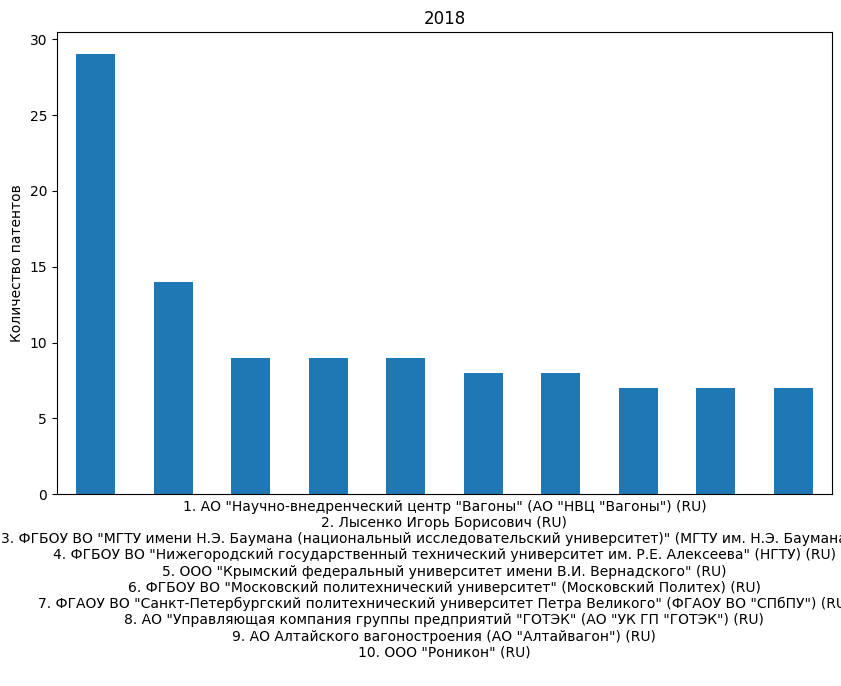




++++++++++++++++++++++++ 2019 ++++++++++++++++++++++++++++
1. Федеральное государственное автономное образовательное учреждение высшего образования "Крымский федеральный университет имени В.И. Вернадского" (RU)
2. Кашичкина Елена Евгеньевна (RU)
3. Яблочко Сергей Викторович (RU)
4. Акционерное общество Алтайского вагоностроения (АО "Алтайвагон") (RU)
5. ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ИННОВАЦИОННЫЕ ТЕХНОЛОГИИ НА ЖЕЛЕЗНОДОРОЖНОМ ТРАНСПОРТЕ" (ООО "ИТЖТ") (RU)
6. федеральное государственное автономное образовательное учреждение высшего образования "Национальный исследовательский университет ИТМО" (Университет ИТМО) (RU)
7. Общество с ограниченной ответственностью Торговый дом "Кемеровский экспериментальный завод средств безопасности" (ООО ТД "КЭЗСБ") (RU)
8. Непокульчицкий Евгений Александрович (RU)
9. ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "СФЕРА" (ООО "СФЕРА") (RU)
10. Российская Федерация, от имени которой выступает ФОНД ПЕРСПЕКТИВНЫХ ИССЛЕДОВАНИЙ (RU)



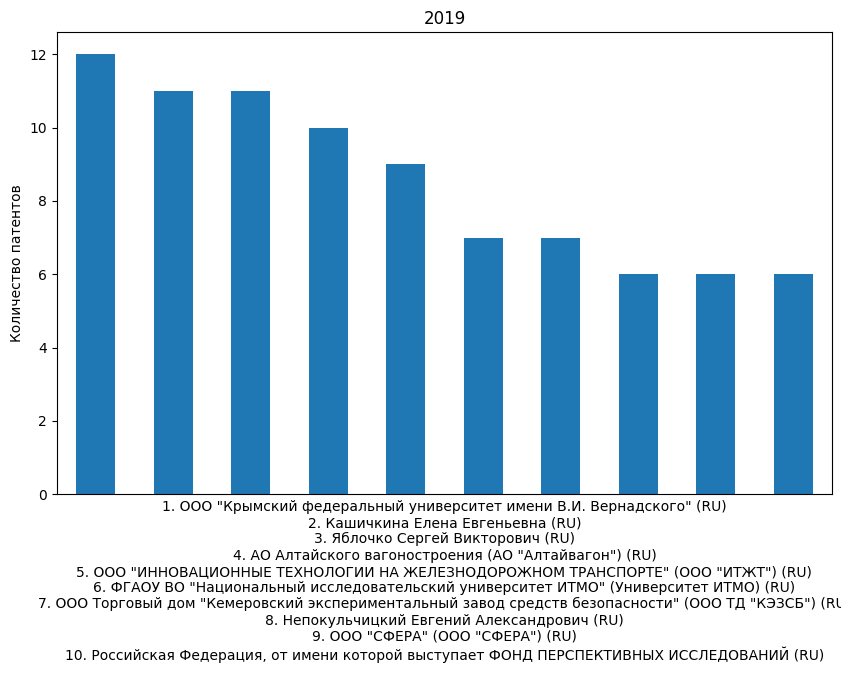




++++++++++++++++++++++++ 2020 ++++++++++++++++++++++++++++
1. Акционерное общество Алтайского вагоностроения (АО "Алтайвагон") (RU)
2. Российская Федерация, от имени которой выступает ФОНД ПЕРСПЕКТИВНЫХ ИССЛЕДОВАНИЙ (RU)
3. ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "АВГУСТ ДИЭСДЖИ" (RU)
4. Публичное акционерное общество "Северсталь" (ПАО "Северсталь") (RU)
5. Яблочко Сергей Викторович (RU)
6. Общество с ограниченной ответственностью "Техномаш" (RU)
7. Общество с ограниченной ответственностью "Информационные технологии" (ООО "ИнфоТех") (RU)
8. Акционерное общество "Термостойкие изделия и инженерные разработки" (АО "ТИИР") (RU)
9. ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "АБТРОНИКС" (ООО "АБТРОНИКС") (RU)
10. Карташян Вадим Эдуардович (RU)



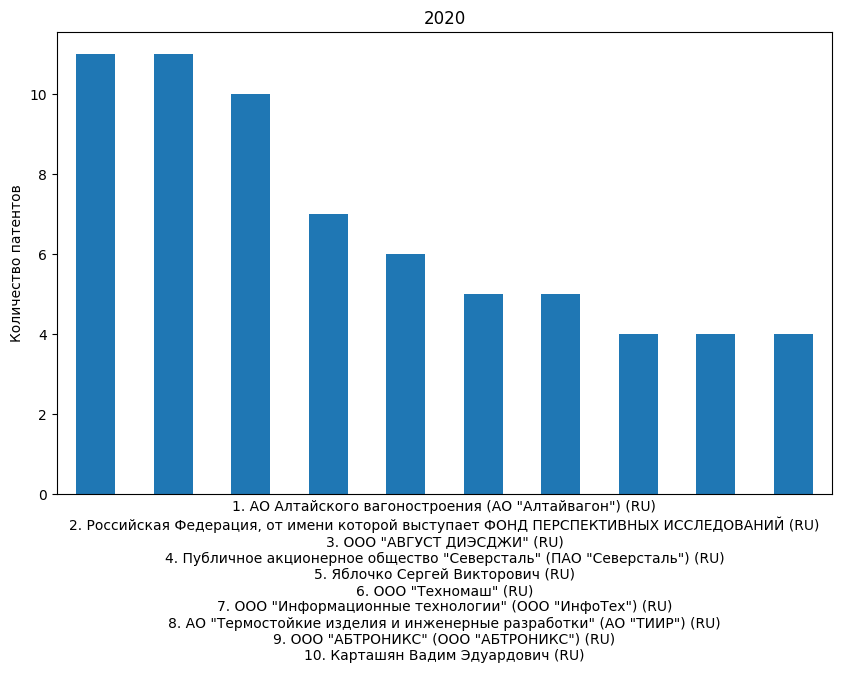




++++++++++++++++++++++++ 2021 ++++++++++++++++++++++++++++
1. ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ" (ООО "ИНФОТЕХ") (RU)
2. Акционерное общество Алтайского вагоностроения (АО "Алтайвагон") (RU)
3. Открытое акционерное общество Всероссийский научно-исследовательский, проектно-конструкторский и технологический институт кабельной промышленности (RU)
4. Дубовик Александр Семенович (RU)
5. Сон Петр Беняминович (RU)
6. Полин Дмитрий Николаевич (RU)
7. Задорожный Артем Анатольевич (RU)
8. ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "КСК ИНЖИНИРИНГ" (ООО "КСК ИНЖИНИРИНГ") (RU)
9. Федеральное государственное автономное научное учреждение "Центральный научно-исследовательский и опытно-конструкторский институт робототехники и технической кибернетики" (ЦНИИ РТК) (RU)
10. Исаков Дмитрий Анатольевич (RU)



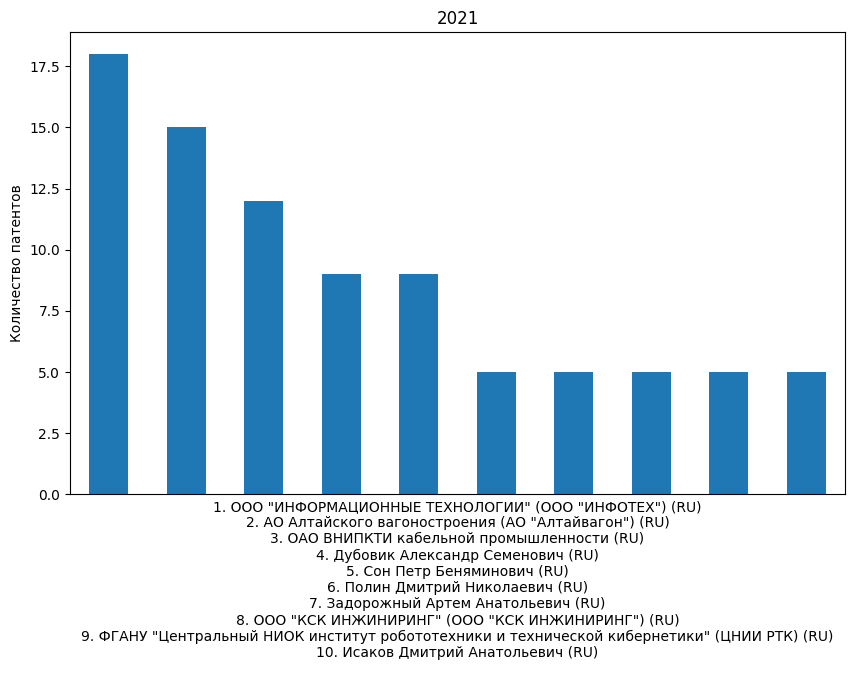




++++++++++++++++++++++++ 2022 ++++++++++++++++++++++++++++
1. Кашичкина Елена Евгеньевна (RU)
2. Акционерное общество Алтайского вагоностроения (АО "Алтайвагон") (RU)
3. Языков Андрей Юрьевич (RU)
4. Российская Федерация, от имени которой выступает ФОНД ПЕРСПЕКТИВНЫХ ИССЛЕДОВАНИЙ (RU)
5. Общество с ограниченной ответственностью "ТЕХНОЛОГИИ-69" (RU)
6. Общество с ограниченной ответственностью "Научно-исследовательский центр "НефтеГазМетрология" (ООО "НИЦ "НГМ") (RU)
7. Мамлясов Юрий Николаевич (RU)
8. Ефременко Владимир Николаевич (RU)
9. ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ КОНСТРУКТОРСКОЕ БЮРО "НОРЛАБ" (RU)
10. Дубовик Александр Семенович (RU)



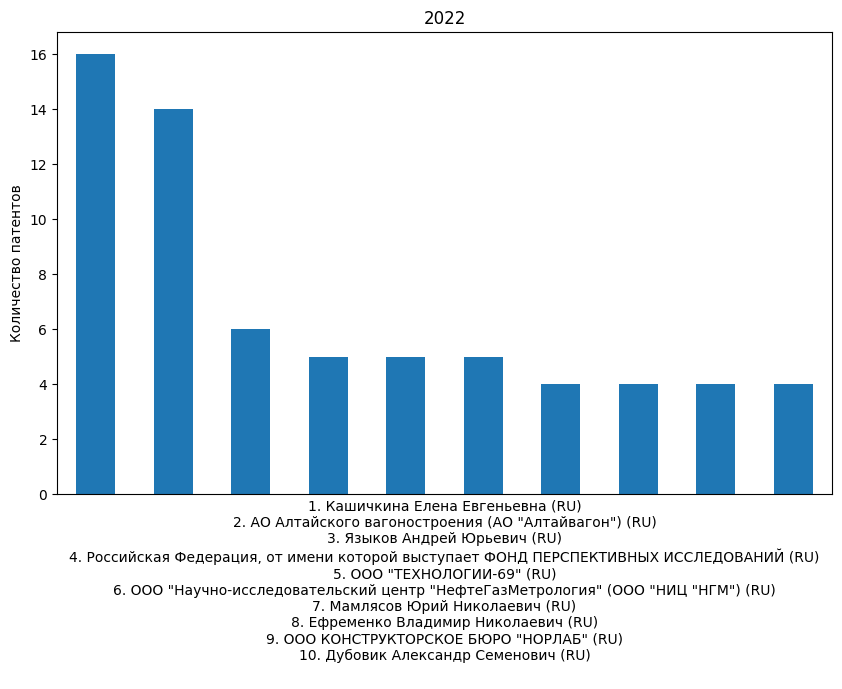

In [ ]:
# самые успешные патентообладатели
for year in years:
  print('++++++++++++++++++++++++', year, '++++++++++++++++++++++++++++')
  top_patents = unique_license_data_voc_ru[year]['owner'].value_counts().iloc[:5]
  top_patents_visual = unique_license_data_voc_ru[year]['owner'].value_counts().iloc[:10]
  counter = 1
  x_label_text = ''
  for patent in top_patents_visual.index:
    x_label_text = x_label_text + str(counter) + '. ' + str((unique_license_data_voc_ru[year][unique_license_data_voc_ru[year]['owner']==patent][['owner', 'title']].values.tolist()[0])[0] + '\n')
    counter += 1
  print(x_label_text)
  x_label_text = x_label_text.replace('федеральное государственное бюджетное образовательное учреждение высшего образования', 'ФГБОУ ВО')
  x_label_text = x_label_text.replace('Акционерное общество', 'АО')
  x_label_text = x_label_text.replace('Общество с ограниченной ответственностью', 'ООО')
  x_label_text = x_label_text.replace('ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ', 'ООО')
  x_label_text = x_label_text.replace('Федеральное государственное автономное образовательное учреждение высшего образования', 'ООО')
  x_label_text = x_label_text.replace('Открытое акционерное общество', 'ОАО')
  x_label_text = x_label_text.replace('Приватное акционерное общество', 'ПАО')
  x_label_text = x_label_text.replace('научно-исследовательский институт', 'НИИ')
  x_label_text = x_label_text.replace('федеральное государственное автономное образовательное учреждение высшего образования', 'ФГАОУ ВО')
  x_label_text = x_label_text.replace('Всероссийский научно-исследовательский, проектно-конструкторский и технологический институт', 'ВНИПКТИ')
  x_label_text = x_label_text.replace('Инженерно-технологический центр', 'ИТЦ')
  x_label_text = x_label_text.replace('Московский государственный технический университет', 'МГТУ')
  x_label_text = x_label_text.replace('Федеральное государственное бюджетное образовательное учреждение высшего образования', 'ФГБОУ ВО')
  x_label_text = x_label_text.replace('Федеральное государственное автономное научное учреждение', 'ФГАНУ')
  x_label_text = x_label_text.replace('научно-исследовательский и опытно-конструкторский', 'НИОК')

  ax = top_patents_visual.plot(kind='bar', figsize=figsize, xlabel=x_label_text, xticks=[], ylabel='Количество патентов', legend=False, title=year)
  plt.show()

  print('\n\n')



In [ ]:
for year in years:
  print(year)
  sber = license_data_voc_ru[year][license_data_voc_ru[year]['licensee'].str.contains('Сбербанк России')]
  print(sber['patent number'])

2018
1450    180108
1533    180145
1536    180146
Name: patent number, dtype: int64
2019
222    196489
Name: patent number, dtype: int64
2020
Series([], Name: patent number, dtype: int64)
2021
Series([], Name: patent number, dtype: int64)
2022
242    212105
Name: patent number, dtype: int64
